## generating sample data
Lets start by generating some data based on parameters.
Our ideal observer will expect two center frequencies (`mu's`) and two widths (`sigma's`).

For our sample data:
+ `mu_true`: are 4 and 23
+ `sigma_true`: are 1.2 and 4.6 (so fairly sharp and fairly wide)
+ `Z`: 70% sampled from a, and 30% sampled from b

We sample a total of 500000 points

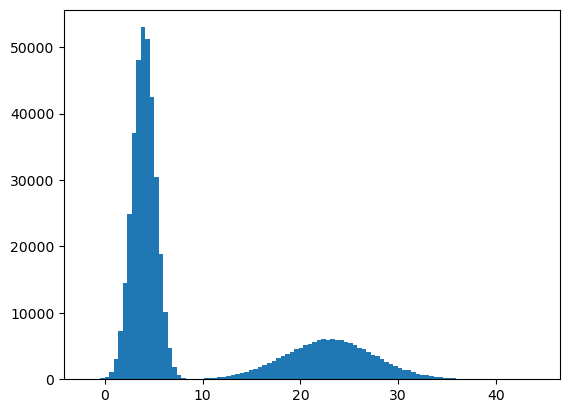

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Mixture components
mu_true = np.array([4, 23])
sigma_true = np.array([1.2, 4.6])

# Determine Z_i
Z = np.random.binomial(1, 0.3, 500000)

# Sample from mixture model
X = np.random.normal(loc=mu_true[Z], scale=sigma_true[Z], size=500000)

# Create a histogram
plt.hist(X, bins=100)
plt.show()


### estimating the multigaussian
We can use `sklearn.mixture.GaussianMixture` to quickly estimate a multigaussian (with in this case 2 components).
As you can see, with this many sampling points the estimated means and sigmas is very close to the input values.

In [11]:
import numpy as np
from sklearn.mixture import GaussianMixture

# Define the number of components (in your case, 2 for two Gaussians)
n_components = 2

# Initialize the Gaussian Mixture model
gmm = GaussianMixture(n_components=n_components)

# Fit the model to the data
gmm.fit(X.reshape(-1, 1))  # Reshape data to match GMM input format - uses Expectation-maximization algorithm

# Get the estimated parameters
estimated_means = gmm.means_.flatten()
estimated_variances = gmm.covariances_.flatten()
estimated_weights = gmm.weights_.flatten()

print("Estimated Means:", estimated_means)
print("Estimated Variances:", estimated_variances)
print("Estimated Sigma:", np.sqrt(estimated_variances))
print("Estimated Mixing Coefficients:", estimated_weights)

Estimated Means: [ 3.99546362 22.98065303]
Estimated Variances: [ 1.44035906 21.19863803]
Estimated Sigma: [1.2001496  4.60419787]
Estimated Mixing Coefficients: [0.70046846 0.29953154]


### estimating the log liklihood based on the gaussian
We can now extract the probabilities and log probability (surprisal) from these values, based on the position on the two gaussians. Try giving in some x_new values and see if this makes sense.

In [134]:
# new value of x
x_new = 30

# get estimated parameters of gaussian mixture
weights = estimated_weights
mu = estimated_means
sigma = np.sqrt(estimated_variances)

# caluculate log liklihoods
likelihoods = weights * norm.pdf(x_new, loc=mu, scale=sigma)
likelihood = np.sum(likelihoods)

# surprise
surprise = -np.log(likelihood)

/scratch/jorvhar/50241822.dccn-l029.dccn.nl/ipykernel_19913/2378458390.py:14: RuntimeWarning: divide by zero encountered in log
  surprise = -np.log(likelihood)


## itterate over block and conditions
In the real world (and in the experiment) we are dealing with limited sampling. 
Meaning we can only use past information to infer future states. 
We do this by itterating over the stimuli step-by-step and estimating our multi-gaussian based on this.

We still expect 2 componenents, but now also have to set a context window, this is the number of values we look back into the past and use this information for estimating our multi-gaussian.

+ please insert your own df_beh to make this code work

Note: We sampled all our tones in frequency_oct (log2) space, this is also how we humans percieve audio - a doubling in frequency sounds one step higher in pitch. For the cleanest results always take the `frequency_oct` values.

In [12]:
## predefine settings
n_components = 2    # number of components / nr of gaussians
context_window = 0  # set maximum context window to integrate: 0 means infinite context window

# Initialize the Gaussian Mixture model
gmm = GaussianMixture(n_components=n_components)

# for block in df_beh['block'].unique():
#     block_oct_dat = df_beh.loc[df_beh['block'] == block, 'frequencies_oct'].to_numpy()

# fatch block octave data
block_oct_dat = df_beh.loc[df_beh['block'] == 1, 'frequencies_oct'].to_numpy()

# predefine arrays
est_meanz   = np.zeros((2, len(block_oct_dat)))
est_varz    = np.zeros((2, len(block_oct_dat)))
est_sigmaz  = np.zeros((2, len(block_oct_dat)))
est_weightz = np.zeros((2, len(block_oct_dat)))
est_meanz[:] = np.nan
est_varz[:] = np.nan
est_sigmaz[:] = np.nan
est_weightz[:] = np.nan

# set where to start itterating
if context_window < n_components:
    startpoint = n_components
else:
    startpoint = context_window
    
# loop over all the tones
for tone in np.arange(startpoint, len(block_oct_dat)):
    
    # cummalative data
    if context_window == 0:
        cum_data = block_oct_dat[:tone]
    else:
        cum_data = block_oct_dat[tone-context_window:tone]

        
    # Fit the model to the data
    gmm.fit(cum_data.reshape(-1, 1))  # Reshape data to match GMM input format

    # Get the estimated parameters
    estimated_means = gmm.means_.flatten()
    estimated_variances = gmm.covariances_.flatten()
    estimated_sigmas = np.sqrt(estimated_variances)
    estimated_weights = gmm.weights_.flatten()
    
    # sort my mean and get indexes - to always match this sorting
    idx = np.argsort(estimated_means)
    
    # save
    est_meanz[:, tone] = estimated_means[idx]
    est_varz[:, tone] = estimated_variances[idx]
    est_sigmaz[:, tone] = estimated_sigmas[idx]
    est_weightz[:, tone] = estimated_weights[idx]

NameError: name 'df_beh' is not defined

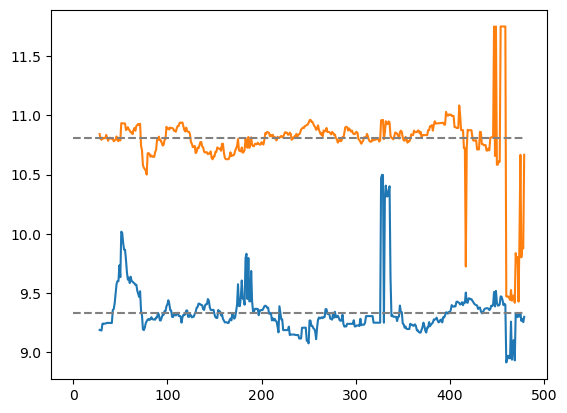

In [195]:
# ideal observer
plt.plot(est_meanz.T)

# real
plt.plot(df_beh.loc[df_beh['block'] == 1, 'center_freq_a_oct'], color='grey', ls='--')
plt.plot(df_beh.loc[df_beh['block'] == 1, 'center_freq_b_oct'], color='grey', ls='--')

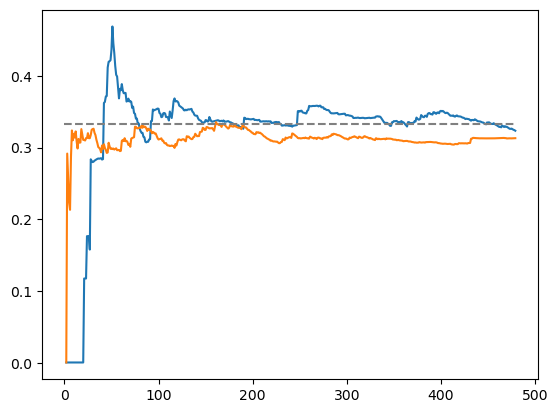

In [199]:
# ideal observer
plt.plot(est_sigmaz.T)

# real
plt.plot(np.ones(len(est_sigmaz.T)) /3, color='grey', ls='--')

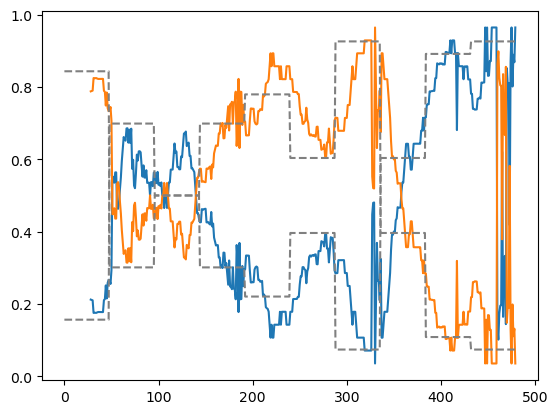

In [197]:
# ideal observer
plt.plot(est_weightz.T)

# real
plt.plot(df_beh.loc[df_beh['block'] == 1, 'probability_a'], color='grey', ls='--')
plt.plot(df_beh.loc[df_beh['block'] == 1, 'probability_b'], color='grey', ls='--')